In [1]:
import h5py
import numpy as np 
with h5py.File('images_training.h5','r') as H:
    data = np.copy(H['data']) 
with h5py.File('labels_training.h5','r') as H:
    label = np.copy(H['label'])

/Users/geyang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
m=data.shape[1]*data.shape[2]
data1 = data.reshape(30000,m)
del data

In [3]:
target = set()
for i in label:
    target.add(i)
d = len(list(target))
d

10

In [4]:
# ovr, label "1" vs. not label "1" 
label1 = np.array([])
for i in range(d):
    label_tmp=np.copy(label)
    for tmp in range(len(label_tmp)):
        if label_tmp[tmp] != i:
            label_tmp[tmp] = 0
        else:
            label_tmp[tmp] = 1
    label_tmp= label_tmp.reshape(-1,1)
    if i == 0:
        label1 = np.copy(label_tmp)
    else:
        label1 = np.append(label1, label_tmp, axis=1)
del label_tmp

In [5]:
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
mindata = data1.min(axis=0)
maxdata = data1.max(axis=0)
data_normalize = (data1-mindata) / (maxdata - mindata)

In [6]:
# # used scikit-learn library, need to implemenet ourselve later
# from sklearn.preprocessing import normalize,StandardScaler
# # data_normalize = normalize(data1)
# scaler = StandardScaler().fit(data1)
# data_normalize = scaler.transform(data1)
# del data1

In [7]:
class PCA():
    def calculate_covariance_matrix(self, X, Y=None):
        # 计算协方差矩阵

        m = X.shape[0]
        X = X - np.mean(X, axis=0)
        Y = X if Y == None else Y - np.mean(Y, axis=0)
        return 1 / m * np.matmul(X.T, Y)

    def transform(self, X, n_components):
        # 设n=X.shape[1]，将n维数据降维成n_component维

        covariance_matrix = self.calculate_covariance_matrix(X)

        # 获取特征值，和特征向量
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # 对特征向量排序，并取最大的前n_component组
        idx = eigenvalues.argsort()[::-1]
        eigenvectors = eigenvectors[:, idx]
        eigenvectors = eigenvectors[:, :n_components]

        # 转换
        return np.matmul(X, eigenvectors), eigenvectors


In [8]:
# (10,700, 10)

data_normalize, eigenvectors = PCA().transform(data_normalize, 300)

In [9]:
eigenvectors.shape

(784, 300)

In [10]:
data_normalize.shape

(30000, 300)

In [11]:
forw0 = np.full((data_normalize.shape[0], 1), 1)
data_normalize = np.append(data_normalize, forw0, axis=1)
data_normalize.shape

(30000, 301)

In [12]:
def f(w, data,label):
    data = np.matrix(data)
    label = np.matrix(label)
    w = np.matrix(w)
    
    w=w.reshape(-1,1)
    
    z = data.dot(w)
    return np.sum(np.log(1+np.exp(z))- np.multiply(label,z) ,axis=0)


def jacobian(weights,inputs, targets ):
#     (weights, inputs, targets)
    inputs = np.matrix(inputs)
    targets = np.matrix(targets)
    weights = np.matrix(weights)
    weights=weights.reshape(-1,1)
    
    z = np.dot(inputs, weights)
    exp_z = np.exp(z)
#     print(exp_z)
    temp = -exp_z/(1 + exp_z) + targets
    dloss = -np.sum(np.multiply(temp,inputs), axis=0)
    dloss = dloss.flatten()
    return dloss

In [13]:

from scipy.optimize import minimize
import numpy.linalg as lng
import time
# weights = np.random.random(data1.shape[1])[:, np.newaxis]
weights = np.array([])
t1 = time.time()
for i in range(d):
#     weight = np.random.random(data_normalize.shape[1])[:, np.newaxis]
    weight = np.full((data_normalize.shape[1], 1), 0.1)
    current_label = (label1[:,i]).reshape(-1,1)
    print(i)
    p = {"maxiter":400}

    result = minimize(f, weight,
                      jac =jacobian,method="L-BFGS-B",tol=1e-4,
                      args=(data_normalize,current_label), options = p) 
    weight = (result.x).reshape(-1,1)
#     print(weight.shape)
    if i == 0:
        weights = weight
    else:
        weights = np.append(weights, weight, axis = 1)
t2 = time.time() 


0
1
2
3
4
5
6
7
8
9


In [14]:
print(str(t2-t1),"seconds")

81.56629514694214 seconds


In [15]:
with h5py.File('images_testing.h5','r') as H:
    data_testing = np.copy(H['data']) 
with h5py.File('labels_testing_2000.h5','r') as H:
    label_testing = np.copy(H['label'])
    
data_testing = np.delete(data_testing, np.s_[2000:5000], 0)

data_testing = data_testing.reshape(2000,-1)
data_testing = (data_testing-mindata) / (maxdata - mindata)
data_testing = np.matmul(data_testing, eigenvectors)



In [16]:
forw0 = np.full((data_testing.shape[0], 1), 1)
data_testing = np.append(data_testing, forw0[0:2000], axis=1)
print(data_testing.shape)
print(label_testing.shape)
calculation = data_testing.dot(weights)
calculation
result = np.argmax(calculation, axis=1)
result.shape

(2000, 301)
(2000,)


(2000,)

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
confusion_matrix(label_testing, result)
cm = confusion_matrix(label_testing, result, labels=[0,1,2,3,4,5,6,7,8,9])
cm

array([[149,   1,   1,   9,   0,   0,  15,   0,   3,   0],
       [  0, 187,   0,   4,   0,   0,   0,   0,   0,   0],
       [  6,   0, 149,   2,  37,   0,  13,   0,   3,   0],
       [  5,   1,   2, 172,   6,   0,   4,   0,   1,   0],
       [  0,   0,  25,  11, 160,   0,  14,   0,   2,   0],
       [  2,   0,   0,   1,   0, 196,   0,   8,   1,   6],
       [ 29,   1,  28,  10,  27,   0,  99,   0,   6,   0],
       [  0,   0,   0,   0,   0,   6,   0, 185,   0,   7],
       [  0,   0,   1,   3,   1,   1,   2,   2, 209,   0],
       [  0,   0,   0,   0,   0,   1,   0,   4,   1, 181]])

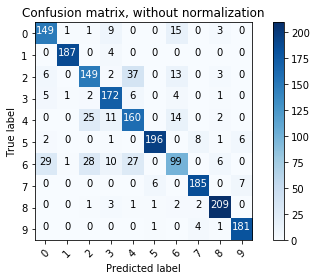

In [43]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(label_testing, result)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix, without normalization')


plt.show()

In [72]:
idx = 0
precisions = []
recalls = []
f1s = [] 
for idx in range(10):
    diag = cm[idx][idx]
    precision = round(diag/np.sum(cm[:,idx]),3)
    recall = round(diag/np.sum(cm[idx]),3)
    f1 = round((2*recall*precision)/(recall+precision),3)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print("for label",idx, " precision is ",precision," recall is ",recall," f1 is ",f1)

for label 0  precision is  0.78  recall is  0.837  f1 is  0.807
for label 1  precision is  0.984  recall is  0.979  f1 is  0.981
for label 2  precision is  0.723  recall is  0.71  f1 is  0.716
for label 3  precision is  0.811  recall is  0.901  f1 is  0.854
for label 4  precision is  0.693  recall is  0.755  f1 is  0.723
for label 5  precision is  0.961  recall is  0.916  f1 is  0.938
for label 6  precision is  0.673  recall is  0.495  f1 is  0.57
for label 7  precision is  0.93  recall is  0.934  f1 is  0.932
for label 8  precision is  0.925  recall is  0.954  f1 is  0.939
for label 9  precision is  0.933  recall is  0.968  f1 is  0.95


In [74]:
print("for label 0 to 9")
print(precisions)
print(recalls)
print(f1s)

for label 0 to 9
[0.78, 0.984, 0.723, 0.811, 0.693, 0.961, 0.673, 0.93, 0.925, 0.933]
[0.837, 0.979, 0.71, 0.901, 0.755, 0.916, 0.495, 0.934, 0.954, 0.968]
[0.807, 0.981, 0.716, 0.854, 0.723, 0.938, 0.57, 0.932, 0.939, 0.95]


In [18]:
print(accuracy_score(label_testing, result)*100, "%")

84.35000000000001 %


In [19]:
# #from tutorial
# from scipy.special import expit, logit
# def logistic_loss_and_grad(weights, inputs, targets):

#     #derivative of the loss function
    
#     z = np.dot(inputs, weights)
    
# #     exp_z = np.exp(z)
#     exp_z = np.exp(z)
#     temp = -exp_z/(1 + exp_z) + targets
# #     print(temp.shape, inputs.shape, (temp*inputs).shape)
#     dloss = -np.sum(temp*inputs, axis=0)[:, np.newaxis]

# #     temp = exp_z/(1 + exp_z) - targets
# #     dloss = np.sum(temp*inputs, axis=0)[:, np.newaxis]


#     return dloss

# import numpy.linalg as lng
# # old_settings = np.seterr(all='ignore')

# # weights = np.random.random(data1.shape[1])[:, np.newaxis]
# weights = np.array([])
# eta = 0.03
# # n_iter = 2000
# n_iter = 2
# eps = 1e-10

# for i in range(d):
#     weight = np.random.random(data_normalize.shape[1])[:, np.newaxis]
#     current_label = (label1[:,i]).reshape(-1,1)
# #     print(weight)
    
#     for epoch in range(n_iter):
#         dloss = logistic_loss_and_grad(weight, data_normalize, current_label)
        
#         weight_new = weight - dloss * eta
#         diff = lng.norm(weight_new - weight)
#         weight = weight_new
#         if diff < eps:
#             break
# #     print(weight_new)
#     if i == 0:
#         weights = weight
#     else:
#         weights = np.append(weights, weight, axis = 1)
    